In [1]:
# Notebook for model evaluation and results

# This notebook evaluates machine learning models on the preprocessed dataset.

In [9]:
# import libraries

import pandas as pd

import torch
import torch.nn as nn

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# get the path from config file

import yaml

with open("../../config.yaml", "r") as file:
    config = yaml.safe_load(file)

raw_data_path = "../../" + config["paths"]["raw_data"]
processed_data_path = "../../" + config["paths"]["processed_data"]
saved_model_path = "../../" + config["paths"]["saved_model"]

In [ ]:
# Define the AutoEncoder model architecture for successfully loading the model

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder part
        self.encoder = nn.Sequential(
            nn.Linear(29, 14),  # Input layer (29 features) -> hidden layer (14 features)
            nn.ReLU(),
            nn.Linear(14, 7),   # Hidden layer -> smaller hidden layer (7 features)
            nn.ReLU(),
            nn.Linear(7, 3),    # Bottleneck layer (compressed representation)
            nn.ReLU()
        )
        
        # Decoder part
        self.decoder = nn.Sequential(
            nn.Linear(3, 7),    # Bottleneck layer -> hidden layer (7 features)
            nn.ReLU(),
            nn.Linear(7, 14),   # Hidden layer -> hidden layer (14 features)
            nn.ReLU(),
            nn.Linear(14, 29),  # Hidden layer -> output layer (29 features)
            nn.Sigmoid()        # To bring the output in range [0,1] (same as input range)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [8]:
# Initialize the model
model = Autoencoder()

# Load the state dictionary
model.load_state_dict(torch.load(f'{saved_model_path}autoencoder_model.pth'))


/var/folders/bl/c9xq73wj61b5k_gjtrh9b0zh0000gn/T/ipykernel_4930/1368495285.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{saved_mode

<All keys matched successfully>

In [10]:
# Load the dataset
df = pd.read_csv(processed_data_path)

# We will train the model on normal data only (unsupervised learning)
X_train = df.values

# Convert data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

In [11]:
# Use the trained model to reconstruct the data

model.eval()  # Switch to evaluation mode

with torch.no_grad():
    reconstructed = model(X_train_tensor)
    
# Compute the reconstruction error (MSE) for each transaction
reconstruction_error = torch.mean((reconstructed - X_train_tensor) ** 2, dim=1)

# Set a threshold for detecting anomalies (fraud)
threshold = torch.quantile(reconstruction_error, 0.95)  # Top 5% as anomalies
print(f"Threshold for anomaly detection: {threshold}")

# Flag transactions with high reconstruction error as fraudulent
fraud_anomalies = reconstruction_error > threshold

Threshold for anomaly detection: 2.337444543838501


True non fraudulent size: 284315
Predicted non fraudulent size: 270099
Predicted fraudulent size: 14216


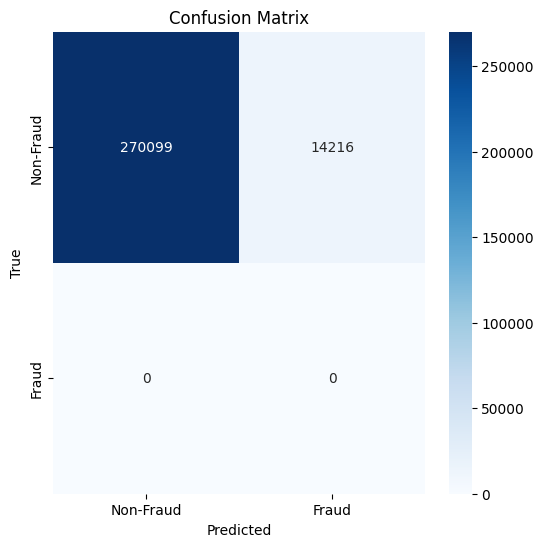

              precision    recall  f1-score        support
0              1.000000  0.949999  0.974359  284315.000000
1              0.000000  0.000000  0.000000       0.000000
accuracy       0.949999  0.949999  0.949999       0.949999
macro avg      0.500000  0.475000  0.487179  284315.000000
weighted avg   1.000000  0.949999  0.974359  284315.000000


/Users/pujan/projects/collections/fraud_detection/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pujan/projects/collections/fraud_detection/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pujan/projects/collections/fraud_detection/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [18]:
import numpy as np

# Get the true labels (fraudulent vs non-fraudulent) for evaluation

raw_data = pd.read_csv(raw_data_path)
y_true = raw_data[raw_data['Class'] == 0]['Class'].values
print(f"True non fraudulent size: {y_true.size}")

# Convert fraud anomalies to 0 (non-fraud) or 1 (fraud)
y_pred = fraud_anomalies.numpy().astype(int)
count_pred_non = (y_pred == 0).sum().item()
count_pred_fraud = (y_pred == 1).sum().item()
print(f"Predicted non fraudulent size: {count_pred_non}")
print(f"Predicted fraudulent size: {count_pred_fraud}")

# Generate a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report as a dictionary
report = classification_report(y_true, y_pred, output_dict=True)

# Convert the report to a pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Save the report to a CSV file
report_df.to_csv('../../results/reports/classification_report.csv', index=True)

# Display the DataFrame
print(report_df)

/Users/pujan/projects/collections/fraud_detection/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


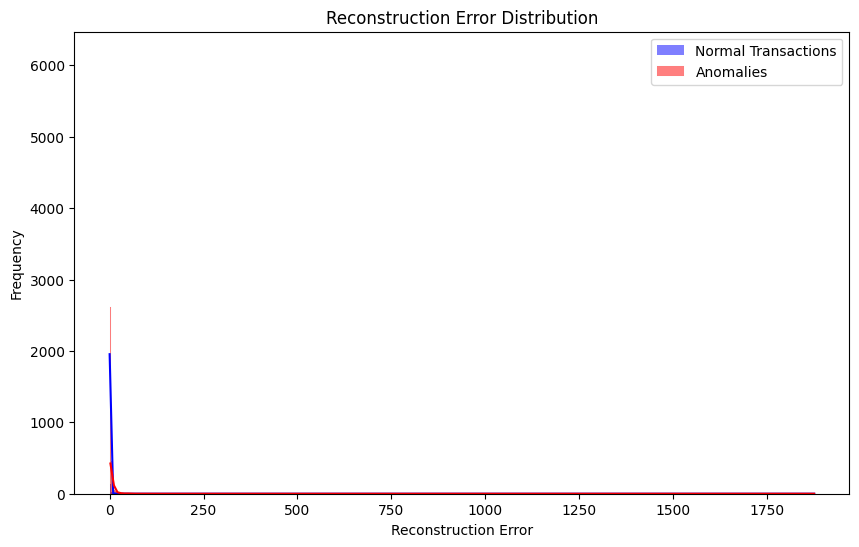

In [14]:
# Plot the reconstruction error
plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_error.numpy(), kde=True, color='blue', label='Normal Transactions')
sns.histplot(reconstruction_error[fraud_anomalies].numpy(), kde=True, color='red', label='Anomalies')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()